## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [27]:
from keras.layers import BatchNormalization, Activation, Dropout, regularizers

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0., l2_ratio=0.):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   kernel_regularizer=regularizers.l2(l2_ratio),
                                   name="hidden_layer"+str(i+1))(input_layer)

            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Dropout(drp_ratio)(x)

        else:
            x = keras.layers.Dense(units=n_units, 
                                   kernel_regularizer=regularizers.l2(l2_ratio),
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Dropout(drp_ratio)(x)
            
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [28]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 30
BATCH_SIZE = 128

"""
建立實驗組合
"""
Dropout_EXP = [0.1, 0,25, 0.5]
L2_RATIO = [0., 1e-6, 1e-8]

#MOMENTUM = 0.95
#OPTIMIZER = keras.optimizers.SGD()
#Dropout_EXP = [0.1, 0,25, 0.5]
#PATTERN = l2

In [29]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for i, (drp_ratio, l2_ratio) in enumerate(itertools.product(Dropout_EXP, L2_RATIO)):
    
    keras.backend.clear_session()
    print("Numbers of exp: %i, drp_ratio: %.2f, l2_ratio: %.2f" % (i, drp_ratio, l2_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], output_units=10, drp_ratio=drp_ratio, l2_ratio=l2_ratio)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              verbose=1,
              shuffle=True)
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, drp_ratio: 0.10, l2_ratio: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Ba

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 36s 729us/step - loss: 1.6850 - acc: 0.3992 - val_loss: 2.3204 - val_acc: 0.2880
Epoch 2/30
50000/50000 [==============================] - 35s 695us/step - loss: 1.4636 - acc: 0.4782 - val_loss: 1.6425 - val_acc: 0.4191
Epoch 3/30
50000/50000 [==============================] - 34s 687us/step - loss: 1.3635 - acc: 0.5172 - val_loss: 1.8426 - val_acc: 0.3724
Epoch 4/30
50000/50000 [==============================] - 34s 676us/step - loss: 1.2882 - acc: 0.5426 - val_loss: 2.1893 - val_acc: 0.3190
Epoch 5/30
50000/50000 [==============================] - 34s 678us/step - loss: 1.2346 - acc: 0.5616 - val_loss: 1.5919 - val_acc: 0.4399
Epoch 6/30
50000/50000 [==============================] - 34s 678us/step - loss: 1.1824 - acc: 0.5795 - val_loss: 1.5617 - val_acc: 0.4465
Epoch 7/30
50000/50000 [==============================] - 34s 679us/step - loss: 1.1396 - acc: 0.5955 - val_loss: 1.

Epoch 13/30
50000/50000 [==============================] - 35s 694us/step - loss: 0.8821 - acc: 0.6854 - val_loss: 1.4547 - val_acc: 0.5000
Epoch 14/30
50000/50000 [==============================] - 35s 693us/step - loss: 0.8472 - acc: 0.6974 - val_loss: 1.5810 - val_acc: 0.4680
Epoch 15/30
50000/50000 [==============================] - 35s 694us/step - loss: 0.8103 - acc: 0.7096 - val_loss: 1.8524 - val_acc: 0.4392
Epoch 16/30
50000/50000 [==============================] - 35s 694us/step - loss: 0.7773 - acc: 0.7219 - val_loss: 1.8380 - val_acc: 0.4507
Epoch 17/30
50000/50000 [==============================] - 35s 694us/step - loss: 0.7475 - acc: 0.7342 - val_loss: 1.4425 - val_acc: 0.5155
Epoch 18/30
50000/50000 [==============================] - 35s 695us/step - loss: 0.7109 - acc: 0.7448 - val_loss: 1.7336 - val_acc: 0.4590
Epoch 19/30
50000/50000 [==============================] - 34s 686us/step - loss: 0.6859 - acc: 0.7543 - val_loss: 1.6935 - val_acc: 0.4715
Epoch 20/30
50000/50

50000/50000 [==============================] - 29s 581us/step - loss: 0.2069 - acc: 0.9278 - val_loss: 2.9882 - val_acc: 0.4629
Epoch 26/30
50000/50000 [==============================] - 29s 583us/step - loss: 0.1902 - acc: 0.9329 - val_loss: 3.1341 - val_acc: 0.4383
Epoch 27/30
50000/50000 [==============================] - 29s 582us/step - loss: 0.1730 - acc: 0.9399 - val_loss: 2.9261 - val_acc: 0.4729
Epoch 28/30
50000/50000 [==============================] - 29s 585us/step - loss: 0.1752 - acc: 0.9384 - val_loss: 2.8706 - val_acc: 0.4802
Epoch 29/30
50000/50000 [==============================] - 29s 575us/step - loss: 0.1734 - acc: 0.9394 - val_loss: 3.3353 - val_acc: 0.4358
Epoch 30/30
50000/50000 [==============================] - 28s 565us/step - loss: 0.1596 - acc: 0.9440 - val_loss: 2.6201 - val_acc: 0.4857
Numbers of exp: 4, drp_ratio: 0.00, l2_ratio: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 35s 693us/step - loss: 1.6124 - acc: 0.4260 - val_loss: 1.7844 - val_acc: 0.3659
Epoch 2/30
50000/50000 [==============================] - 34s 674us/step - loss: 1.3748 - acc: 0.5111 - val_loss: 1.6209 - val_acc: 0.4231
Epoch 3/30
50000/50000 [==============================] - 34s 673us/step - loss: 1.2607 - acc: 0.5505 - val_loss: 1.6437 - val_acc: 0.4219
Epoch 4/30
50000/50000 [==============================] - 34s 674us/step - loss: 1.1687 - acc: 0.5840 - val_loss: 1.8291 - val_acc: 0.3836
Epoch 5/30
50000/50000 [==============================] - 34s 687us/step - loss: 1.0887 - acc: 0.6145 - val_loss: 1.6102 - val_acc: 0.4378
Epoch 6/30
50000/50000 [==============================] - 33s 657us/step - loss: 1.0108 - acc: 0.6398 - val_loss: 1.6489 - val_acc: 0.4211
Epoch 7/30
50000/50000 [==============================] - 33s 656us/step - loss: 0.9398 - acc: 0.6682 - val_loss: 1.

Epoch 13/30
50000/50000 [==============================] - 28s 564us/step - loss: 0.5585 - acc: 0.8025 - val_loss: 1.9629 - val_acc: 0.4398
Epoch 14/30
50000/50000 [==============================] - 28s 564us/step - loss: 0.5015 - acc: 0.8237 - val_loss: 2.1945 - val_acc: 0.4411
Epoch 15/30
50000/50000 [==============================] - 28s 564us/step - loss: 0.4563 - acc: 0.8396 - val_loss: 2.3868 - val_acc: 0.4276
Epoch 16/30
50000/50000 [==============================] - 28s 569us/step - loss: 0.4050 - acc: 0.8576 - val_loss: 2.3292 - val_acc: 0.4465
Epoch 17/30
50000/50000 [==============================] - 28s 564us/step - loss: 0.3735 - acc: 0.8701 - val_loss: 2.2321 - val_acc: 0.4750
Epoch 18/30
50000/50000 [==============================] - 28s 564us/step - loss: 0.3413 - acc: 0.8808 - val_loss: 2.4066 - val_acc: 0.4699
Epoch 19/30
50000/50000 [==============================] - 28s 564us/step - loss: 0.3073 - acc: 0.8929 - val_loss: 2.4248 - val_acc: 0.4679
Epoch 20/30
50000/50

50000/50000 [==============================] - 33s 656us/step - loss: 0.2177 - acc: 0.9293 - val_loss: 3.1302 - val_acc: 0.4593
Epoch 26/30
50000/50000 [==============================] - 33s 655us/step - loss: 0.2111 - acc: 0.9325 - val_loss: 3.0606 - val_acc: 0.4515
Epoch 27/30
50000/50000 [==============================] - 33s 655us/step - loss: 0.2069 - acc: 0.9340 - val_loss: 3.1262 - val_acc: 0.4569
Epoch 28/30
50000/50000 [==============================] - 33s 656us/step - loss: 0.1965 - acc: 0.9365 - val_loss: 2.9701 - val_acc: 0.4669
Epoch 29/30
50000/50000 [==============================] - 33s 656us/step - loss: 0.1780 - acc: 0.9436 - val_loss: 2.9759 - val_acc: 0.4722
Epoch 30/30
50000/50000 [==============================] - 33s 655us/step - loss: 0.1862 - acc: 0.9422 - val_loss: 3.0016 - val_acc: 0.4704
Numbers of exp: 8, drp_ratio: 25.00, l2_ratio: 0.00
_________________________________________________________________
Layer (type)                 Output Shape             

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 31s 620us/step - loss: 2.0514 - acc: 0.2735 - val_loss: 1.7390 - val_acc: 0.3901
Epoch 2/30
50000/50000 [==============================] - 30s 602us/step - loss: 1.7612 - acc: 0.3655 - val_loss: 1.6865 - val_acc: 0.3942
Epoch 3/30
50000/50000 [==============================] - 30s 603us/step - loss: 1.6717 - acc: 0.4009 - val_loss: 1.5846 - val_acc: 0.4372
Epoch 4/30
50000/50000 [==============================] - 30s 603us/step - loss: 1.6122 - acc: 0.4251 - val_loss: 1.6251 - val_acc: 0.4138
Epoch 5/30
50000/50000 [==============================] - 30s 603us/step - loss: 1.5675 - acc: 0.4418 - val_loss: 1.4950 - val_acc: 0.4646
Epoch 6/30
50000/50000 [==============================] - 30s 603us/step - loss: 1.5345 - acc: 0.4537 - val_loss: 1.7229 - val_acc: 0.3822
Epoch 7/30
50000/50000 [==============================] - 30s 603us/step - loss: 1.5081 - acc: 0.4632 - val_loss: 1.

Epoch 13/30
50000/50000 [==============================] - 34s 679us/step - loss: 1.3967 - acc: 0.5076 - val_loss: 1.4582 - val_acc: 0.4743
Epoch 14/30
50000/50000 [==============================] - 34s 679us/step - loss: 1.3784 - acc: 0.5126 - val_loss: 1.4364 - val_acc: 0.4826
Epoch 15/30
50000/50000 [==============================] - 34s 678us/step - loss: 1.3678 - acc: 0.5160 - val_loss: 1.5384 - val_acc: 0.4529
Epoch 16/30
50000/50000 [==============================] - 34s 679us/step - loss: 1.3537 - acc: 0.5236 - val_loss: 1.4560 - val_acc: 0.4825
Epoch 17/30
50000/50000 [==============================] - 34s 679us/step - loss: 1.3354 - acc: 0.5318 - val_loss: 1.5032 - val_acc: 0.4670
Epoch 18/30
50000/50000 [==============================] - 34s 679us/step - loss: 1.3254 - acc: 0.5359 - val_loss: 1.4961 - val_acc: 0.4588
Epoch 19/30
50000/50000 [==============================] - 34s 679us/step - loss: 1.3078 - acc: 0.5421 - val_loss: 1.5965 - val_acc: 0.4388
Epoch 20/30
50000/50

50000/50000 [==============================] - 34s 677us/step - loss: 1.2295 - acc: 0.5675 - val_loss: 1.4525 - val_acc: 0.4822
Epoch 26/30
50000/50000 [==============================] - 34s 678us/step - loss: 1.2285 - acc: 0.5678 - val_loss: 1.5149 - val_acc: 0.4625
Epoch 27/30
50000/50000 [==============================] - 34s 678us/step - loss: 1.2149 - acc: 0.5705 - val_loss: 1.3553 - val_acc: 0.5172
Epoch 28/30
50000/50000 [==============================] - 34s 678us/step - loss: 1.2038 - acc: 0.5774 - val_loss: 1.5220 - val_acc: 0.4589
Epoch 29/30
50000/50000 [==============================] - 34s 678us/step - loss: 1.1886 - acc: 0.5836 - val_loss: 1.4181 - val_acc: 0.4982
Epoch 30/30
50000/50000 [==============================] - 34s 678us/step - loss: 1.1861 - acc: 0.5820 - val_loss: 1.3993 - val_acc: 0.5018


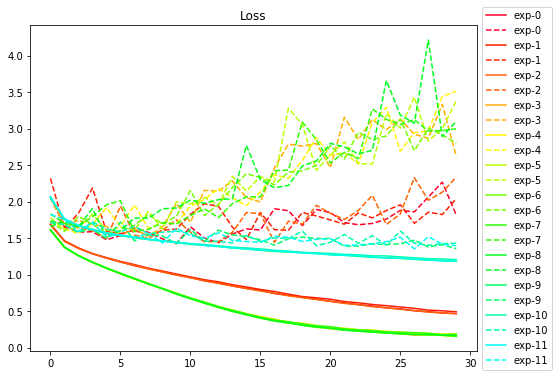

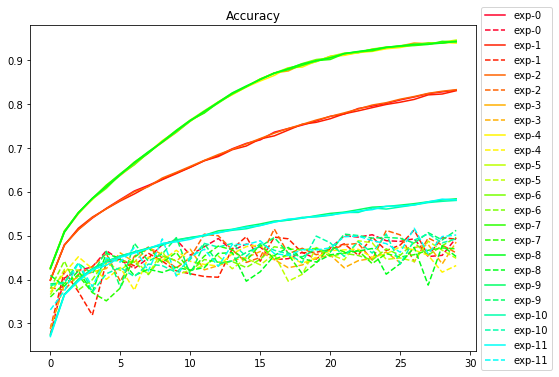

In [30]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline

"""Code Here
將結果繪出
"""
NUM_COLORS = 20
cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()